# Variogram, Correlation and Kriging Estimation (VarioCorreKrigE): Semivariance and Correlation estimation and model fitting
***

In this notebook we explore the cabailities of variofit and correfit on a dataset of Ground-motion residuals which are normalized as per the variance for every event ("evid") meaning that the stations/samples ("sta") corresponding to each event has a mean of zero and a standard deviation of 1. This is import for Variogram and Correlation model estimation as the sill usually tends to 1 and thus the models should also return a fixed sill i.e., 1 for Variograms and 0 for Correlation models.

The examples are broken down as follows:

- variofit Examples:
1) Example 1: fitting a single variogram
2) Example 2: Fitting multiple variograms based on index e.g., a variogram per "evid"
3) Example 3: Exploring weighted variogram fits

- correfit Examples:
1) Example 1: fitting a single correlation model
2) Example 2: Fitting multiple correlation models based on index e.g., a correlation model per "evid"

# 1.0 Import Modules and Data

## 1.1 Import Modules

### 1.1.1 General Use

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

### 1.1.2 variocorrekrige

In [1]:
from VarioCorreKrigE.variofit import variofit, variofitmulti
from VarioCorreKrigE.variofit import powered_exponential
from VarioCorreKrigE.correfit import correfit, correfitmulti
from VarioCorreKrigE.utils import compute_distance_weights, theta_from_params
from VarioCorreKrigE.variofit import VARIOGRAM_MODELS
from VarioCorreKrigE.correfit import CORRELATION_MODELS
print('list of variogram model: ', VARIOGRAM_MODELS)
print('list of correlation models: ', CORRELATION_MODELS)

list of variogram model:  {'spherical': <function spherical at 0x00000142C2EBEE80>, 'exponential': <function exponential at 0x00000142C2EBF100>, 'gaussian': <function gaussian at 0x00000142C2EBF2E0>, 'cubic': <function cubic at 0x00000142C2EBF380>, 'powered_exponential': <function powered_exponential at 0x00000142C2EBF420>, 'matern': <function matern at 0x00000142C2EBF4C0>, 'damped_cosine_angle': <function damped_cosine_angle at 0x00000142C2EBF560>, 'angular_dissimilarity': <function angular_dissimilarity at 0x00000142C2EBF600>}
list of correlation models:  {'spherical': <function spherical at 0x00000142C3912160>, 'exponential': <function exponential at 0x00000142C3912200>, 'gaussian': <function gaussian at 0x00000142C39122A0>, 'cubic': <function cubic at 0x00000142C3912340>, 'powered_exponential': <function powered_exponential at 0x00000142C39123E0>, 'matern': <function matern at 0x00000142C3912480>, 'damped_cosine_angle': <function damped_cosine_angle at 0x00000142C3912520>, 'angular

## 1.2 Import Data

In [3]:
im_dwbar = pd.read_csv(r'Data/im_dwbar.csv')

# 2.0 variofit examples

## 2.1 Example 1: Single Fit

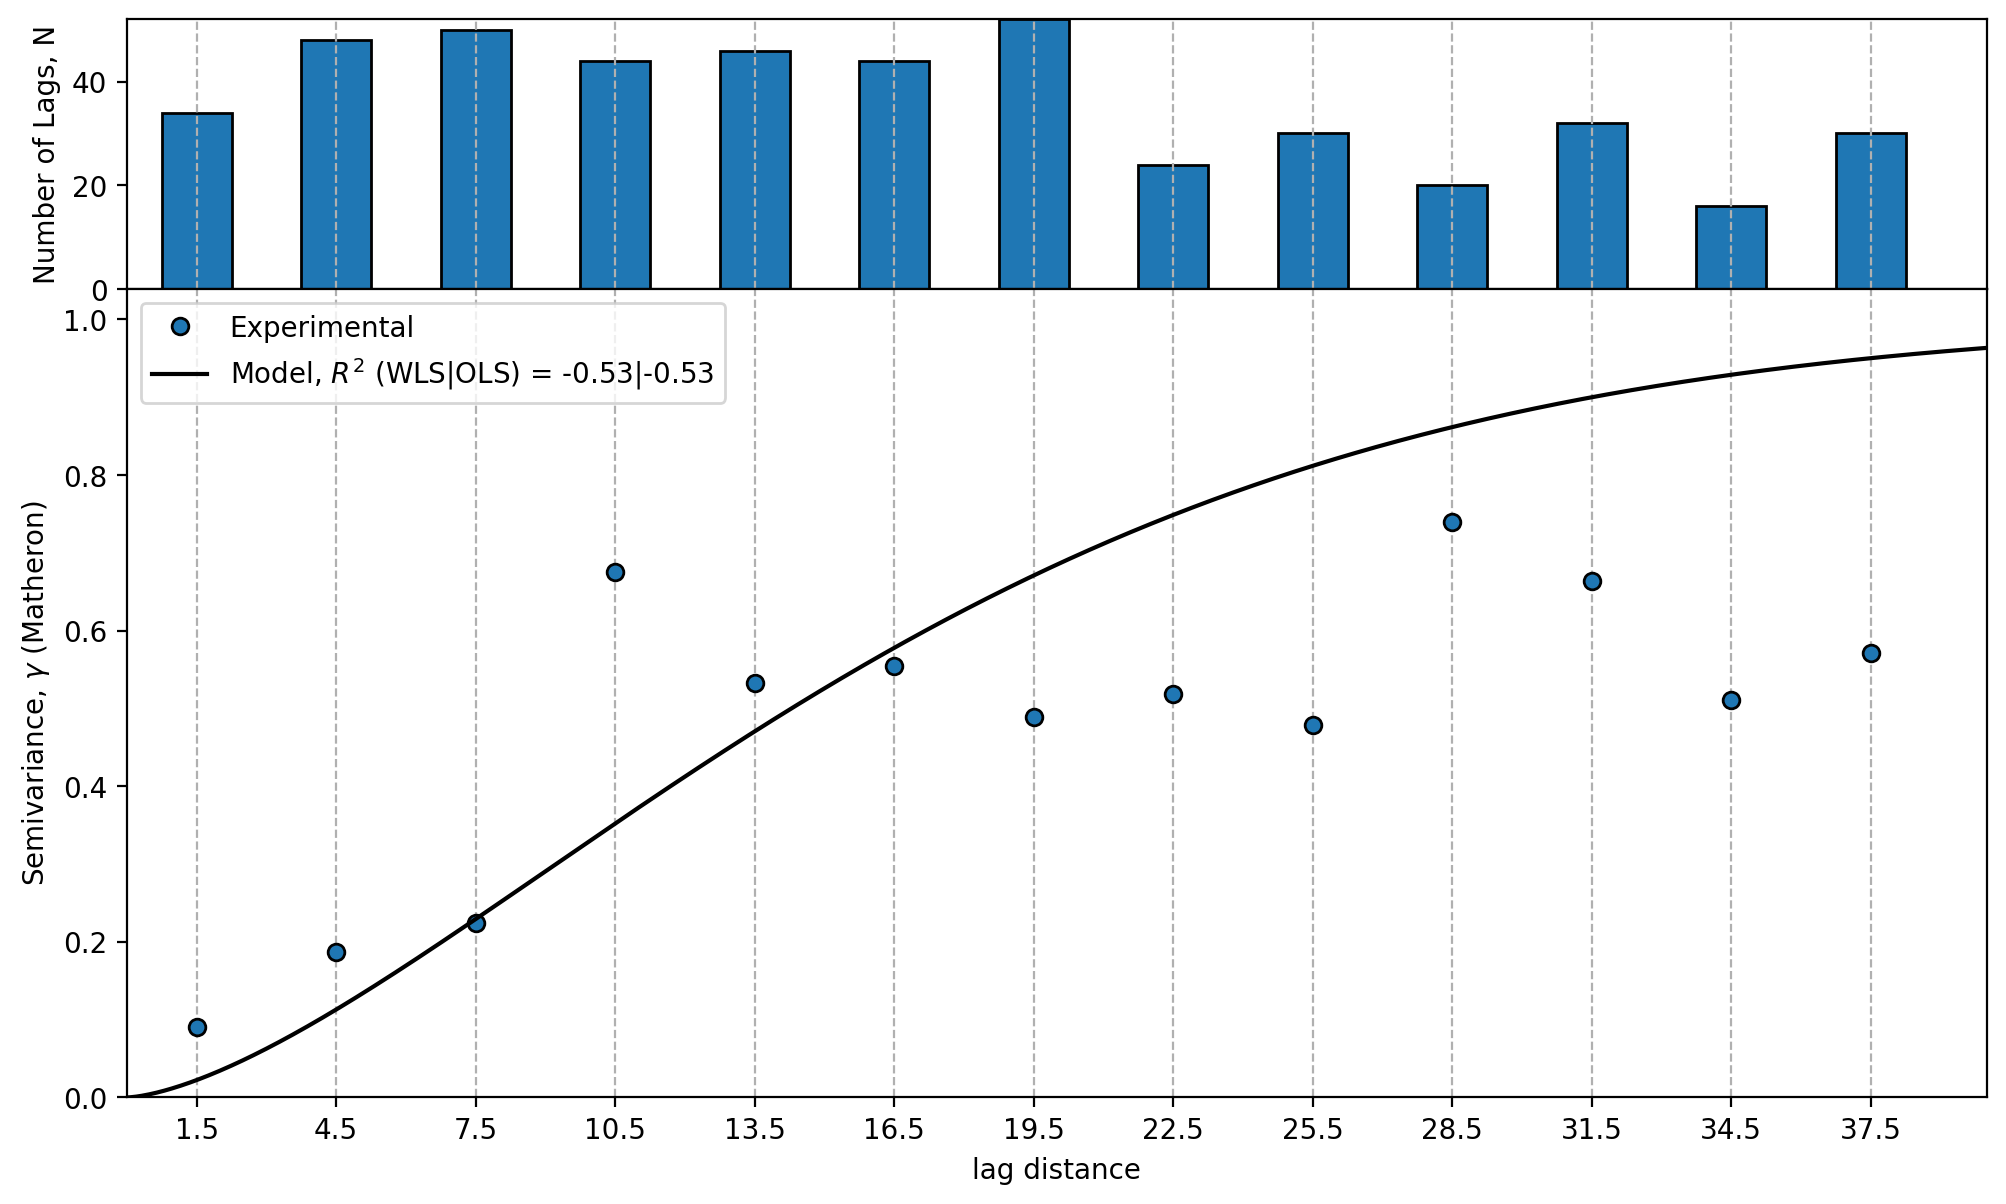

In [4]:
im_dwbar_test = im_dwbar.loc[:67]

estimator = "Matheron"
model = "powered_exponential"
weight_fn = None
weight_params = None
xmax_factor = 1

h_lag, n_obs, gamma, params, r2_wls, r2_ols = variofit(values = im_dwbar_test['pSA_1.0'], coordinates = im_dwbar_test[['lat','lon']], distance_type = 'geographic', max_distance = 40, bin_size = 3, estimator_type= estimator, model_type = model, weight_fn = weight_fn, weight_params = weight_params, xmax_factor=xmax_factor, fix_sill = True, plot = True)

## 2.2 Example 2: Multi-fit

Fitting groups:   0%|          | 0/54 [00:00<?, ?it/s]

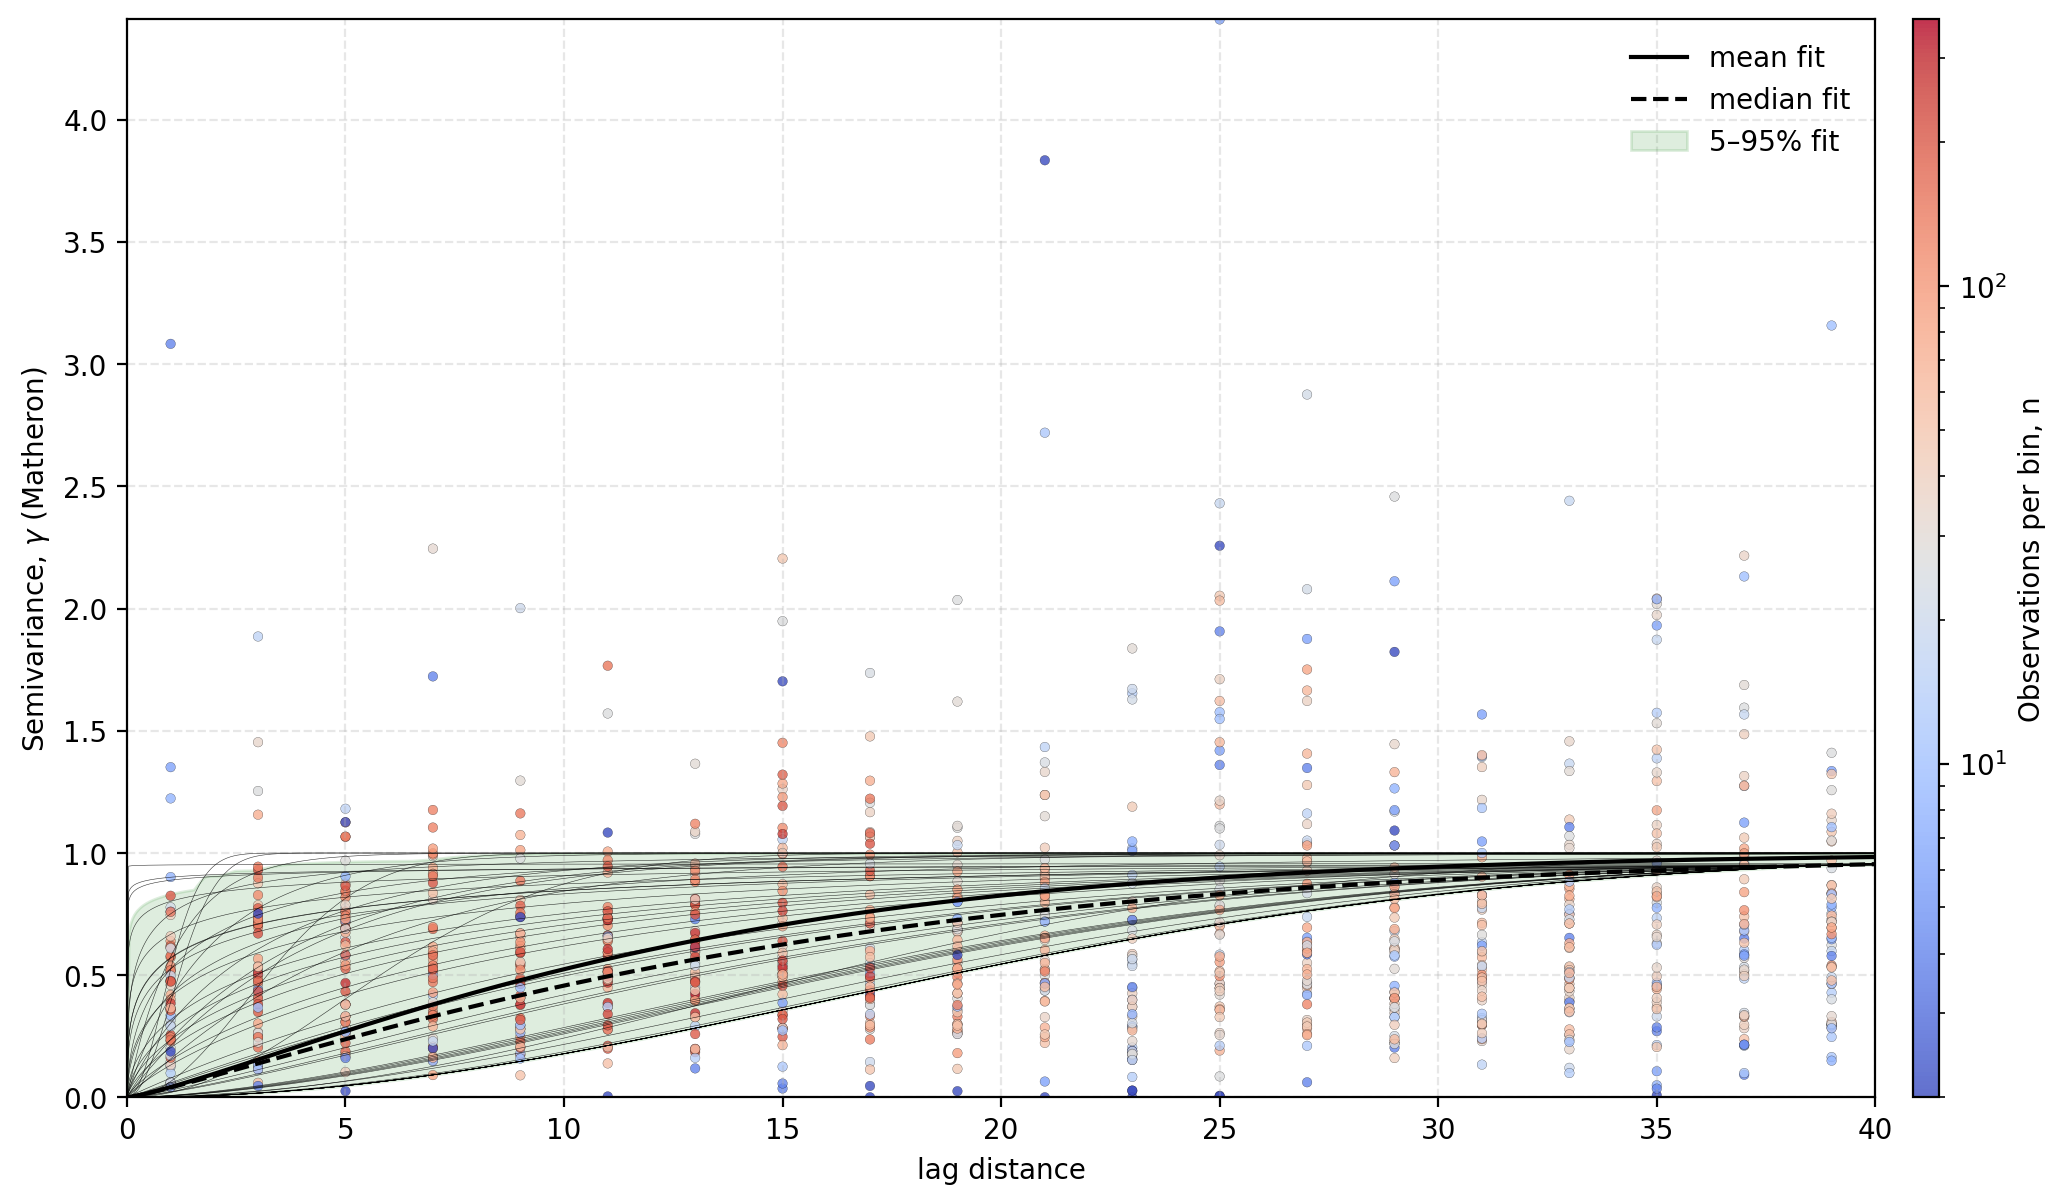

In [5]:
summary, df_n_obs, df_gamma, results = variofitmulti(
    df=im_dwbar,
    values_col="pSA_1.0",
    index_col="evid",
    coord_cols=("lat","lon"),
    distance_type="geographic",
    max_distance=40,
    bin_size=2,
    estimator_type="Matheron",
    model_type="powered_exponential",
    weight_fn=None,
    weight_params=None,
    xmax_factor=1.0,
    fix_sill= True,
    plot_single=False,
    plot_summary=True
)

## 2.3 Example 3: Weighted Fit

We define different distance–weighting schemes $w(h)$ as follows:

1. **Inverse–linear weighting**
   $$w(h) = n_j \cdot \frac{1}{1 + \frac{h}{b}}$$

2. **Exponential weighting**
   $$w(h) = n_j \cdot e^{-\frac{h}{b}}$$

3. **Powered weighting**
   $$w(h) = n_j \cdot \left( 1 + \frac{h}{b} \right)^{-\alpha}$$

4. **Linear weighting**
   $$w(h) = n_j \cdot 1(h)$$
   where $1(h)$ is the constant‐ones function over $h$ and $n_j$ is the number of observations per values of $h$.

These weighting functions are in essence correlation models which decays based on the "lag of interest". It should be noted that for the exponential weighting the "lag of interest" is usually h/3 e.g., if we want to consider points up to 6km, b = 2 as will be seen in the example.


### 2.3.1 Plot of Models with various weight-types

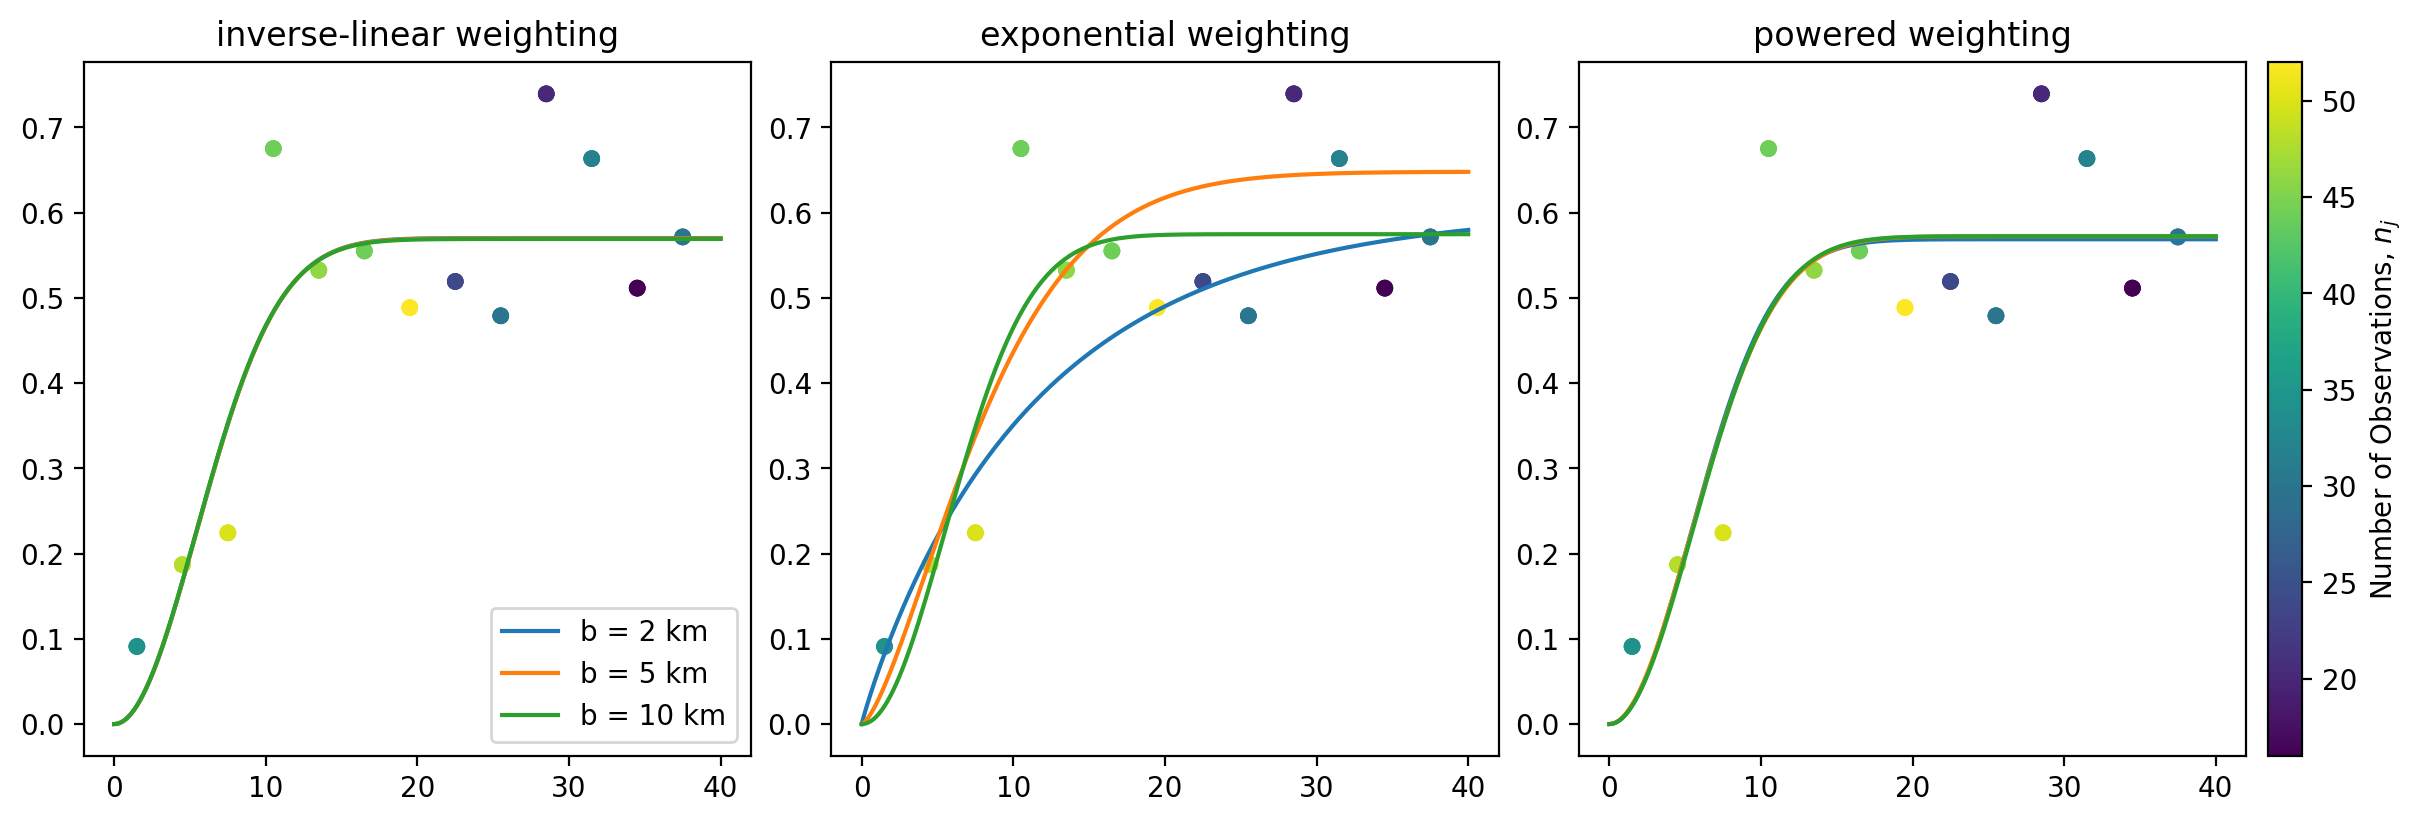

In [24]:
weight_types = ['inverse-linear weighting','exponential weighting','powered weighting']
weight_params = [[2,0.5],[5,1.5],[10,2]]
h = np.arange(0,40+0.1, 0.1)
model = "powered_exponential"

fig, ax = plt.subplots(1,3, figsize = (12,4), dpi = 200, constrained_layout = True)
for i in range(len(weight_params)):
    weight_fn = "inverse-linear weighting"
    h_lag, n_obs, gamma, params, _, _ = variofit(values = im_dwbar_test['pSA_1.0'], coordinates = im_dwbar_test[['lat','lon']], distance_type = 'geographic', max_distance = 40, bin_size = 3, estimator_type= estimator, model_type = model, weight_fn = weight_fn, weight_params = weight_params[i], xmax_factor=xmax_factor, fix_sill = False, plot = False)
    theta = theta_from_params(params, model, family='variogram')
    ax[0].plot(h, powered_exponential(h,theta[0], theta[1], theta[2]), label = 'b = %.0f km'%weight_params[i][0])
    im = ax[0].scatter(h_lag, gamma, c=n_obs, cmap='viridis', s=25)
    ax[0].legend()
    ax[0].set_title('inverse-linear weighting')

    weight_fn = "exponential weighting"
    h_lag, n_obs, gamma, params, _, _ = variofit(values = im_dwbar_test['pSA_1.0'], coordinates = im_dwbar_test[['lat','lon']], distance_type = 'geographic', max_distance = 40, bin_size = 3, estimator_type= estimator, model_type = model, weight_fn = weight_fn, weight_params = weight_params[i], xmax_factor=xmax_factor, fix_sill = False, plot = False)
    theta = theta_from_params(params, model, family='variogram')
    ax[1].plot(h, powered_exponential(h,theta[0], theta[1], theta[2]))
    ax[1].scatter(h_lag, gamma, c=n_obs, cmap='viridis', s=25)
    ax[1].set_title('exponential weighting')

    weight_fn = "powered weighting"
    h_lag, n_obs, gamma, params, _, _ = variofit(values = im_dwbar_test['pSA_1.0'], coordinates = im_dwbar_test[['lat','lon']], distance_type = 'geographic', max_distance = 40, bin_size = 3, estimator_type= estimator, model_type = model, weight_fn = weight_fn, weight_params = weight_params[i], xmax_factor=xmax_factor, fix_sill = False, plot = False)
    theta = theta_from_params(params, model, family='variogram')
    ax[2].plot(h, powered_exponential(h,theta[0], theta[1], theta[2]))
    ax[2].scatter(h_lag, gamma, c=n_obs, cmap='viridis', s=25)
    ax[2].set_title('powered weighting')
cb1 = plt.colorbar(im, ax=ax, pad=0.01, fraction=0.05)
cb1.set_label(r"Number of Observations, $n_j$")
plt.show()

### 2.3.2 Comparing OLS vs. WLS

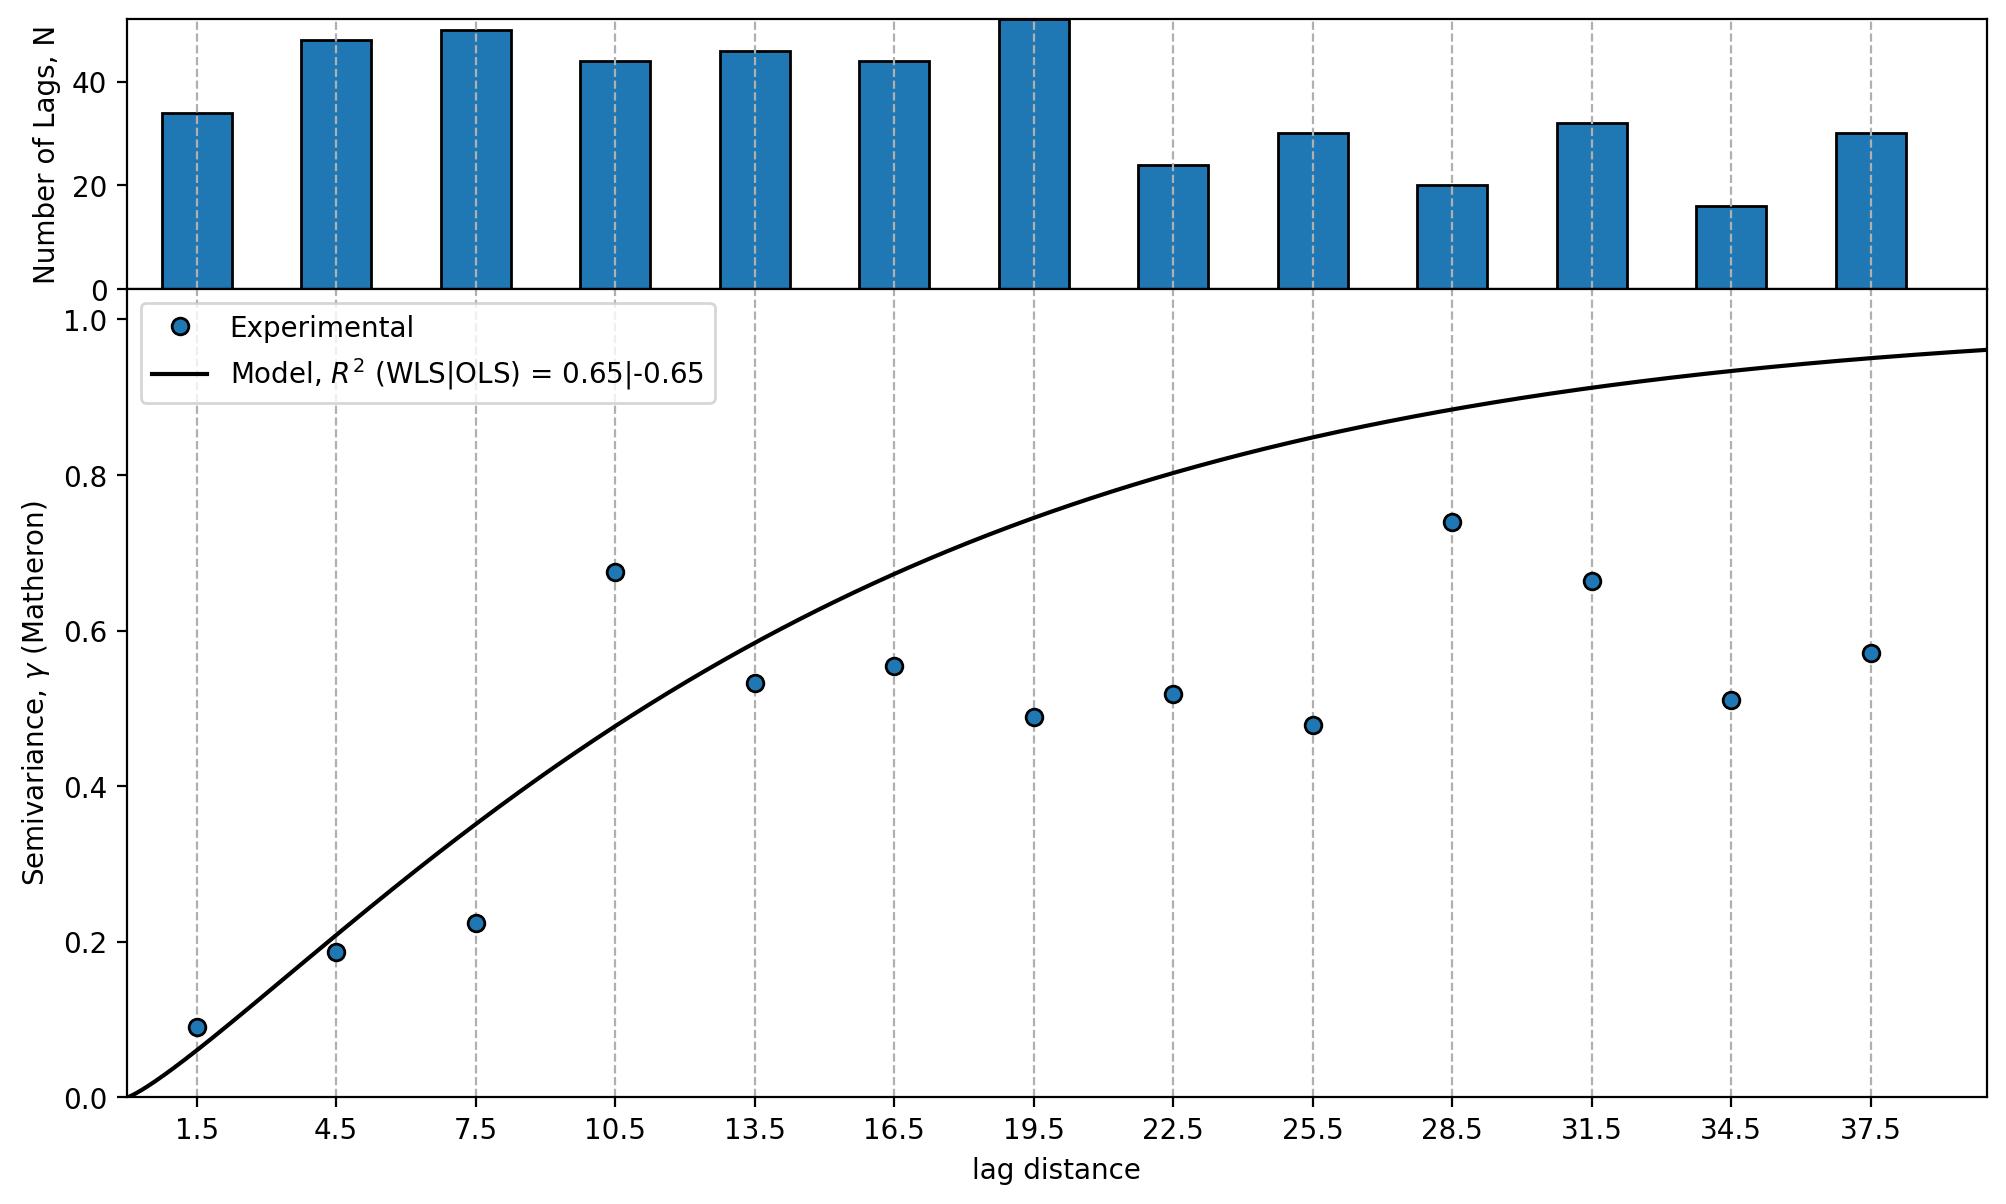

[[1.60604628e+01]
 [5.05916278e+00]
 [1.17588729e+00]
 [2.30890810e-01]
 [5.38604626e-02]
 [1.14953765e-02]
 [3.03132251e-03]
 [3.12175144e-04]
 [8.70696123e-05]
 [1.29519044e-05]
 [4.62393679e-06]
 [5.15869878e-07]
 [2.15823991e-07]]


In [33]:
estimator = "Matheron"
model = "powered_exponential"
weight_fn = "exponential weighting"
weight_params = [2]
xmax_factor = 1

h_lag, n_obs, gamma, params, r2_wls, r2_ols = variofit(values = im_dwbar_test['pSA_1.0'], coordinates = im_dwbar_test[['lat','lon']], distance_type = 'geographic', max_distance = 40, bin_size = 3, estimator_type= estimator, model_type = model, weight_fn = weight_fn, weight_params = weight_params, xmax_factor=xmax_factor, fix_sill = True, plot = True)

w = compute_distance_weights(h_lag, n_obs, weight_fn, weight_params)
print(w)

# 3.0 correfit example

## 3.1 Example 1: Single Fit

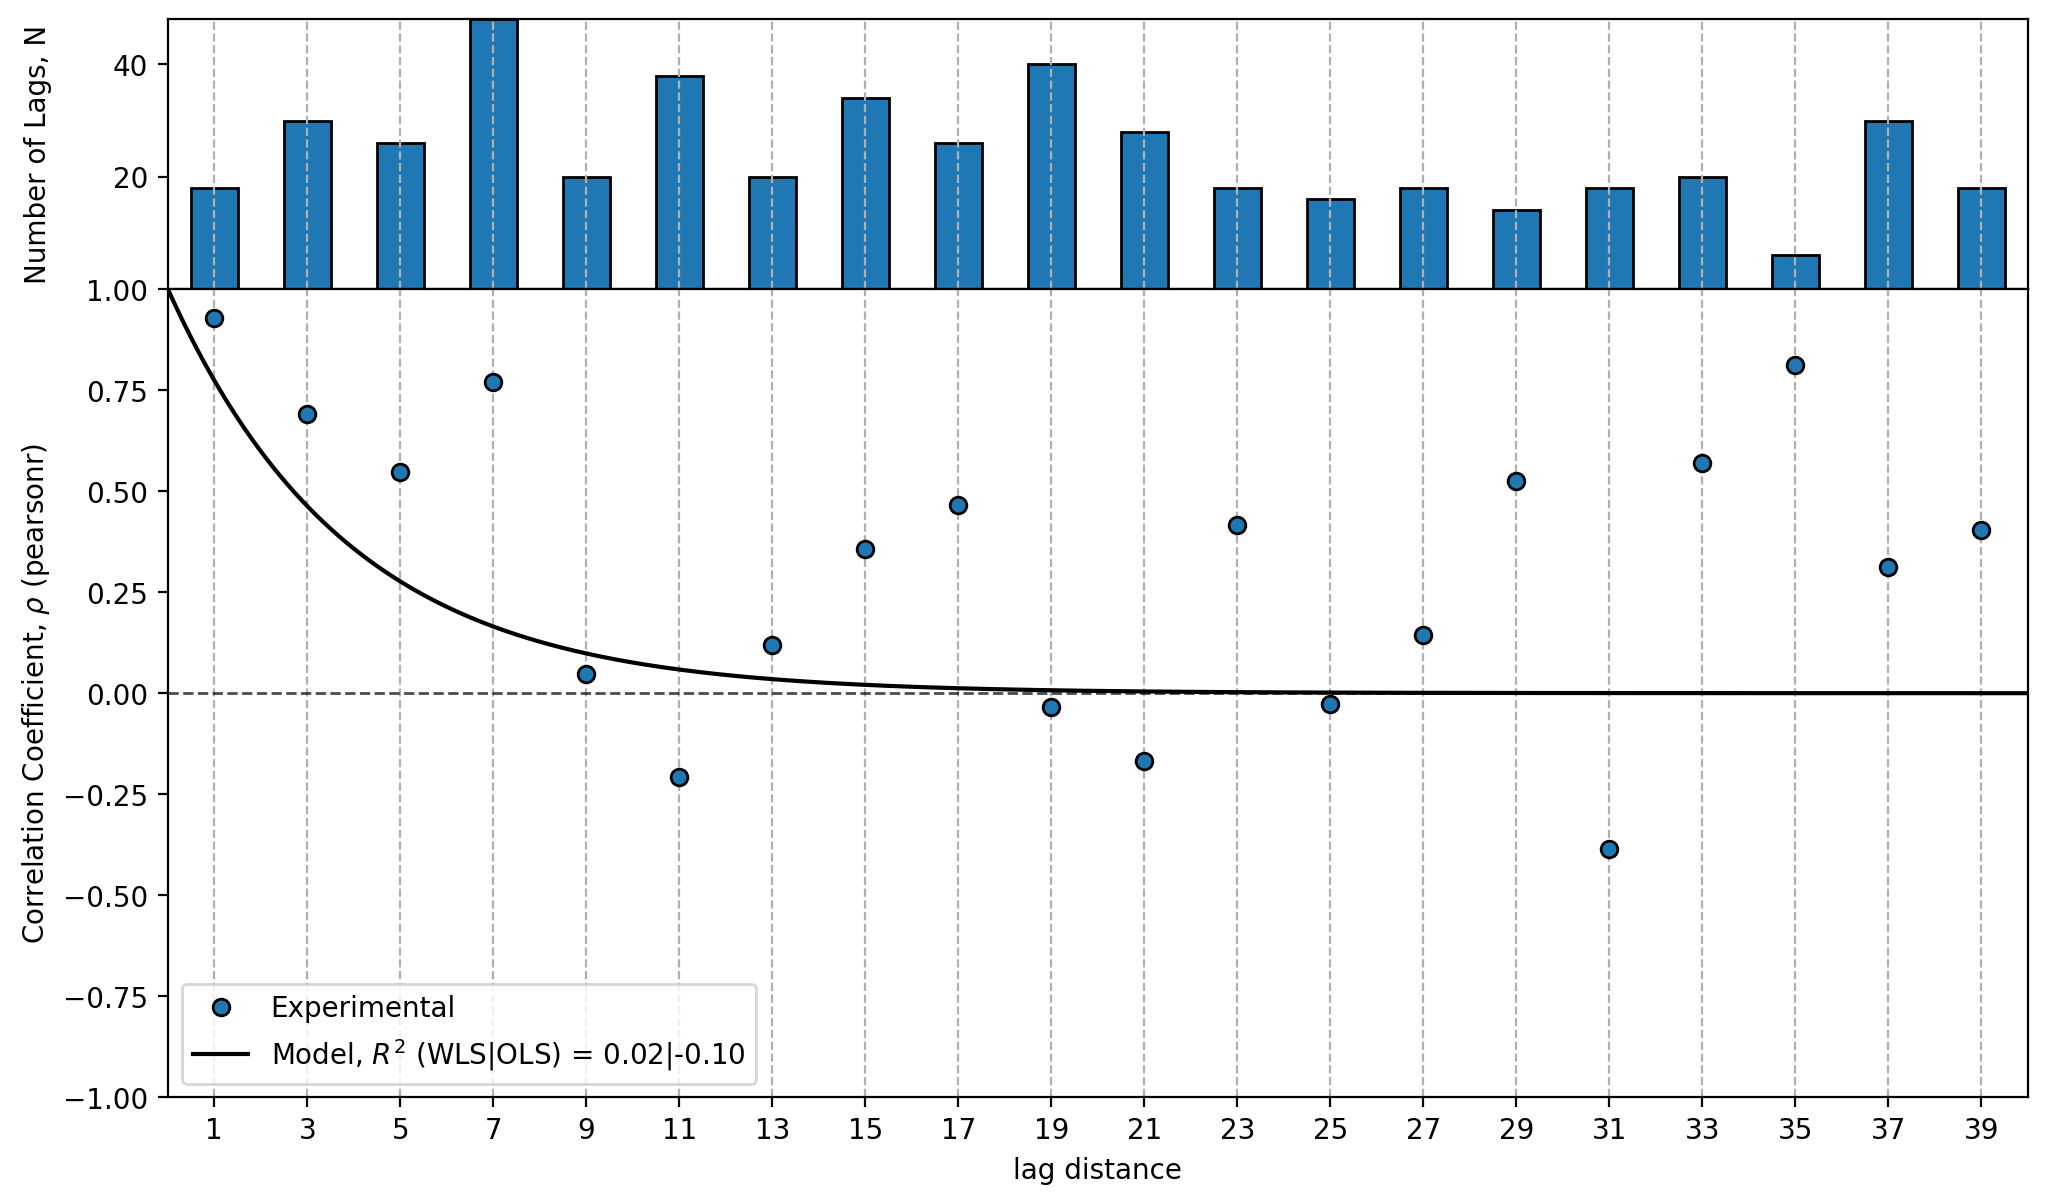

In [6]:
im_dwbar_test = im_dwbar.loc[:67]

correlation = "pearsonr"
model = "damped_cosine_angle"
weight_fn = 'linear weighting'
weight_params = None
xmax_fit = 0.1

h_lag, n_obs, rho, params, r2_wls, r2_ols = correfit(values = im_dwbar_test['pSA_1.0'], coordinates = im_dwbar_test[['lat','lon']], distance_type = 'geographic', max_distance = 40, bin_size = 2, correlation_type= correlation, model_type = model, weight_fn = weight_fn, weight_params = weight_params, max_lagfit_factor=xmax_fit, plot = True)

## 3.2 Example 2: Multi-fit

Fitting groups:   0%|          | 0/54 [00:00<?, ?it/s]

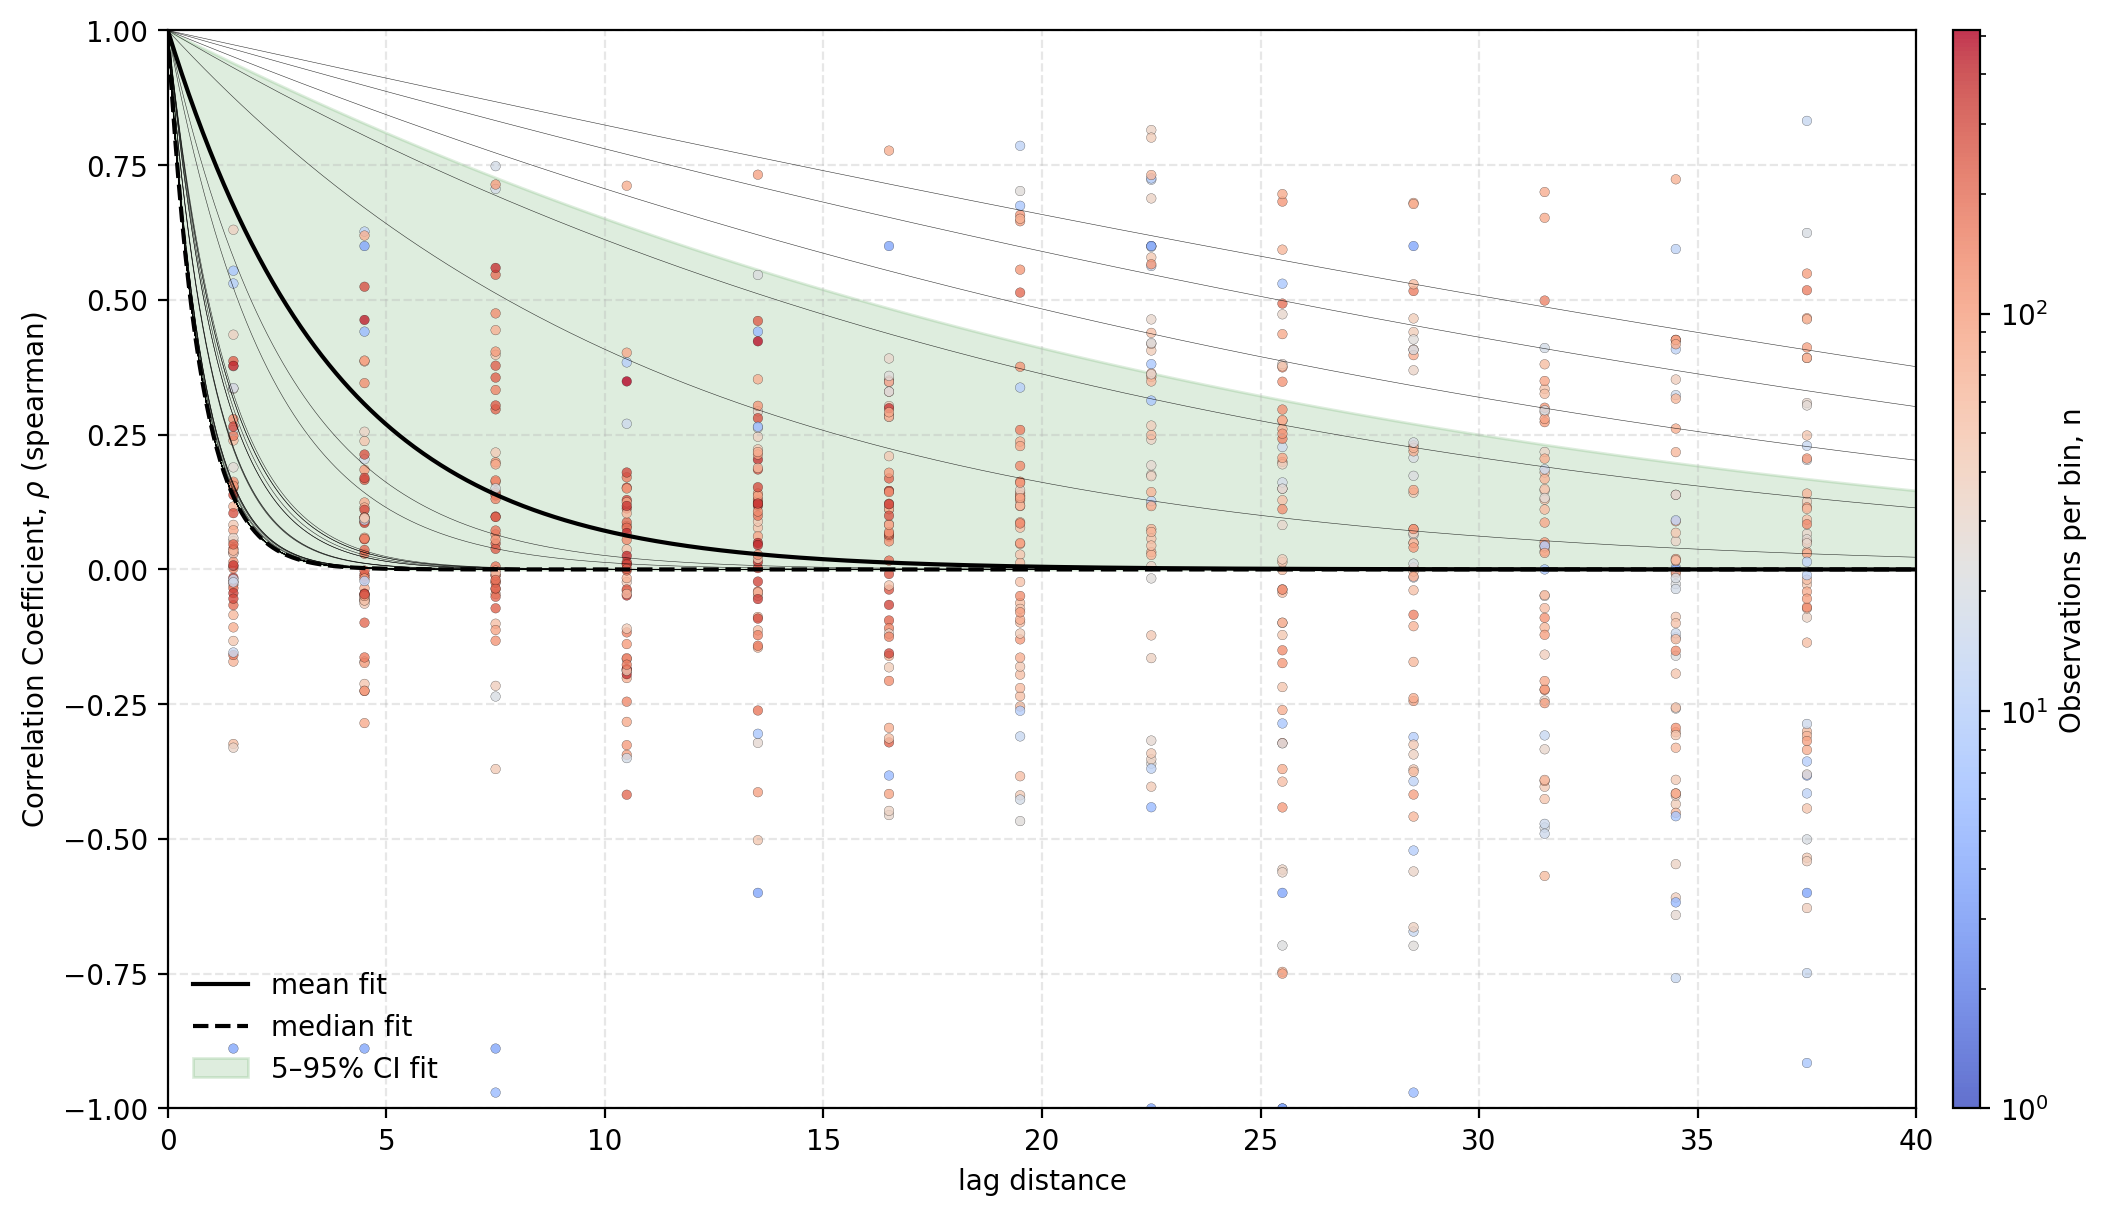

In [7]:
correlation = "spearman"
model = "damped_cosine_angle"
weight_fn = None
weight_params = None
xmax_fit = 1.5

summary, df_n_obs, df_rho, results = correfitmulti(
    df=im_dwbar,
    values_col="pSA_1.0",
    index_col="evid",
    coord_cols=("lat","lon"),
    distance_type="geographic",
    max_distance=40,
    bin_size=3,
    correlation_type=correlation,
    model_type=model,
    weight_fn=weight_fn,
    weight_params=weight_params,
    max_lagfit_factor=xmax_fit,
    fix_alpha = True,
    plot_single=False,
    plot_summary=True
)